In [1]:
# default_exp lstm

In [2]:
# all_func

In [3]:
#hide

from nbdev.showdoc import *

# LSTM Embeddings

> Functions to train and evaluate ML models on embeddings from a pretrained LSTM.

In [4]:
# export

from peptide.imports import *
from peptide.basics import *
from peptide.utils import *
from peptide.learn import Learner
from peptide.data import (
    ACPDataset,
    AMPDataset,
    DNABindDataset,
)

## Load Data

In [5]:
acp_data = ACPDataset(DATA_STORE)
amp_data = AMPDataset(DATA_STORE)
dna_data = DNABindDataset(DATA_STORE)

## Pretrained Model - ProSE

Details of the pretrained model:

Protein Sequence Embeddings (ProSE)
- Multi-task and masked language model-based protein sequence embedding models.
- https://github.com/tbepler/prose

### fasta + BioPython

- Procedure for generating fasta files using the BioPython library is [detailed here in the data module](/peptide/data.html#ProteinDataset.generate_fasta_files).
- fasta files are created by the `generate_fasta_files()` method in the dataset classes for example - `acp_data.generate_fasta_files()`

### Create LSTM Embeddings From fasta

In order to cerate embeddings in bulk from fasta files ..
- the [ProSE Github repo](https://github.com/tbepler/prose) needs to be cloned
- a conda environment for it needs to be created as detailed in the repo (link above)
- then in that conda environment at the root of the cloned repo, the following commands need to be run

Sample python commands to generate embeddings from pretrained model in the ProSE codebase are as follows:

#### ACP

- The following command will generate `average` pooled features from the pretrained ProSE modelfor the sequences in the fasta file provided as input.
- Remove `-d 0` from the command to run on CPU.
```sh
python embed_sequences.py -d 0 --pool avg -o ~/.peptide/datasets/acp/lstm/acp_avgpool_test.h5 ~/.peptide/datasets/acp/fasta/acp_test.fasta
# loading the pre-trained ProSE MT model
# writing: /home/vinod/.peptide/datasets/acp/lstm/acp_avgpool_test.h5
# embedding with pool=avg
```
- Sample command for `max` pooling
```sh
python embed_sequences.py -d 0 --pool max -o ~/.peptide/datasets/acp/lstm/acp_maxpool_train.h5 ~/.peptide/datasets/acp/fasta/acp_train.fasta
# loading the pre-trained ProSE MT model
# writing: /home/vinod/.peptide/datasets/acp/lstm/acp_maxpool_train.h5
# embedding with pool=max
```

#### AMP

- For AMP - some type of pooling needs to be done on the non-truncated sequences as `train` and `test` have different max seq lengths
```sh
python embed_sequences.py -d 0 --pool avg -o ~/.peptide/datasets/amp/lstm/amp_avgpool_train.h5 ~/.peptide/datasets/amp/fasta/amp_train.fasta
# loading the pre-trained ProSE MT model
# writing: /home/vinod/.peptide/datasets/amp/lstm/amp_avgpool_train.h5
# embedding with pool=avg
```
- Truncated data set `max` pool command
```sh
python embed_sequences.py -d 0 --pool max -o ~/.peptide/datasets/amp/lstm/amp_maxpool_test_seqlen_150.h5 ~/.peptide/datasets/amp/fasta/amp_test_seqlen_150.fasta
# loading the pre-trained ProSE MT model
# writing: /home/vinod/.peptide/datasets/amp/lstm/amp_maxpool_test_seqlen_150.h5
# embedding with pool=max
```

#### DNA Binding

- Same as AMP - some pooling needed for the full non-truncated sequences
```sh
python embed_sequences.py -d 0 --pool avg -o ~/.peptide/datasets/dna/lstm/dna_avgpool_test.h5 ~/.peptide/datasets/dna/fasta/dna_test.fasta
# loading the pre-trained ProSE MT model
# writing: /home/vinod/.peptide/datasets/lstm/avg/dnabind_avgpool_test.h5
# embedding with pool=avg
```
- Truncated sequence example with `max` pooling
```sh
python embed_sequences.py -d 0 --pool max -o ~/.peptide/datasets/dna/lstm/dna_maxpool_train_seqlen_300.h5 ~/.peptide/datasets/dna/fasta/dna_train_seqlen_300.fasta
# loading the pre-trained ProSE MT model
# writing: /home/vinod/.peptide/datasets/dna/lstm/dna_maxpool_train_seqlen_300.h5
# embedding with pool=max
```

### Get Embeddings - Read From H5

The procedure for reading the generated embeddings from the H5 file is [detailed here in the data module](peptide/data.html#ProteinDataset.get_lstm_emb).

## Anti Cancer Peptide Dataset (ACP)

### ACP - Dimensionality Reduction (PCA) vs Full Data

In [6]:
X_train, y_train, X_test, y_test = acp_data.get_lstm_emb('acp_avgpool_train.h5', 'acp_avgpool_test.h5')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1378, 6165), (1378,), (344, 6165), (344,))

In [7]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(
    f"Explained variance ratio of the first 10 principal components:\n{pca.explained_variance_ratio_[:10]}"
)

X_train_pca.shape: (1378, 50)
Explained variance ratio of the first 10 principal components:
[0.28138205 0.13824382 0.0479676  0.0339361  0.03260109 0.01959571
 0.01888285 0.0157898  0.01357551 0.01306792]


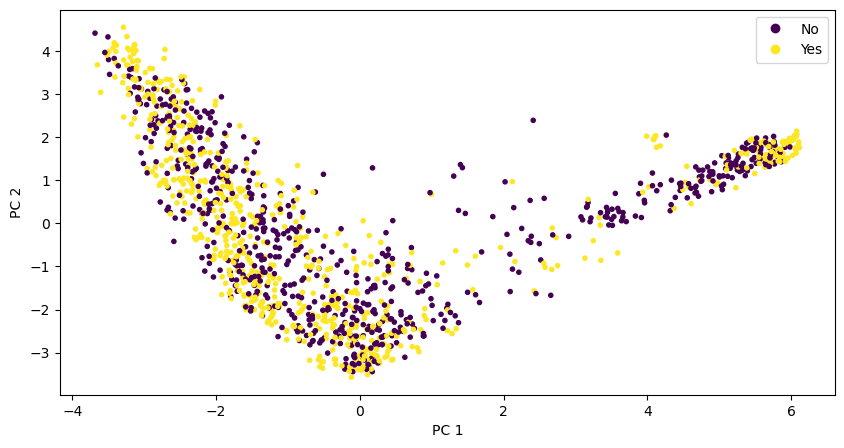

In [8]:
visualize_2pcs(X_train_pca, y_train)

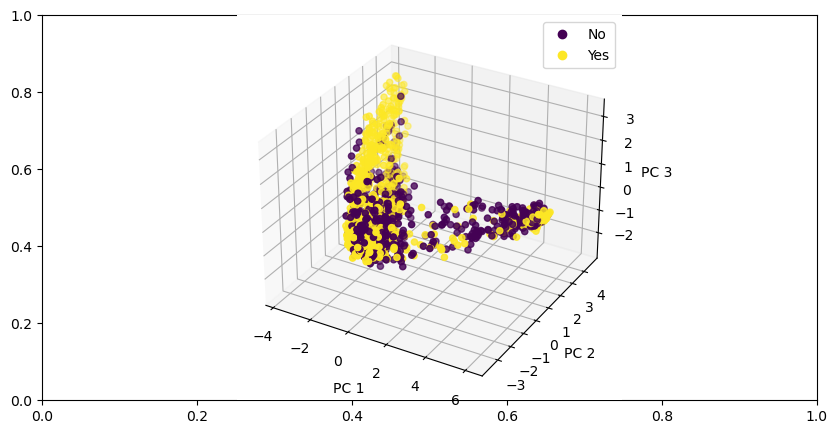

In [9]:
visualize_3pcs(X_train_pca, y_train)

Evaluation on full data

In [10]:
train_predict(X_train, y_train, X_test, y_test)

,acc,recall,precision,f1
lr,0.738372,0.755814,0.730337,0.742857
svc,0.718023,0.761628,0.700535,0.729805
xgb,0.729651,0.773256,0.711230,0.740947


Evaluation on reduced data

In [11]:
X_test_pca = pca.transform(X_test)
train_predict(X_train_pca, y_train, X_test_pca, y_test)

,acc,recall,precision,f1
lr,0.674419,0.720930,0.659574,0.688889
svc,0.665698,0.709302,0.652406,0.679666
xgb,0.735465,0.773256,0.718919,0.745098


### ACP - Get Data and Learners (Avg vs Max Pooling)

In [12]:
# avg pool Learner
X_train, y_train, X_test, y_test = acp_data.get_lstm_emb('acp_avgpool_train.h5', 'acp_avgpool_test.h5')
acp_avgpool_learner = Learner(X_train, y_train, X_test, y_test) 

# max pool Learner
X_train, y_train, X_test, y_test = acp_data.get_lstm_emb('acp_maxpool_train.h5', 'acp_maxpool_test.h5')
acp_maxpool_learner = Learner(X_train, y_train, X_test, y_test) 

### ACP - Grid Search (Supervised Learning)

In [13]:
acp_avgpool_learner.pipeline.steps

[('pca', PCA(n_components=50)), ('classifier', 'passthrough')]

In [14]:
#hide_output

_, _ = acp_avgpool_learner.train()

Starting grid search for LogisticRegression
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Starting grid search for LinearSVC
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2

Starting grid search for XGBClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Run  grid search on max pooled embedding to compare results

In [15]:
#hide_output

_, _ = acp_maxpool_learner.train()

Starting grid search for LogisticRegression
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Starting grid search for LinearSVC
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2

Starting grid search for XGBClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits


### ACP - Label Spreading (Semi Supervised Learning)

In [16]:
acp_maxpool_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       172
           1       0.71      0.70      0.71       172

    accuracy                           0.71       344
   macro avg       0.71      0.71      0.71       344
weighted avg       0.71      0.71      0.71       344



In [17]:
acp_avgpool_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       172
           1       0.74      0.76      0.75       172

    accuracy                           0.74       344
   macro avg       0.74      0.74      0.74       344
weighted avg       0.74      0.74      0.74       344



In case of label spreading - avg pooling performs better 

### ACP - Prediction Results
Comparing prediction performance between `avg` and `max` pooled embedding

In [18]:
acp_avgpool_learner.predict()

,best_params,accuracy,recall,precision,f1
LogisticRegression,"{'classifier': LogisticRegression(C=100.0, max...",0.674419,0.72093,0.659574,0.688889
LinearSVC,"{'classifier': LinearSVC(C=100.0, max_iter=100...",0.65407,0.703488,0.640212,0.67036
XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.732558,0.75,0.724719,0.737143
LabelSpreading,"{'alpha': 0.01, 'gamma': 20, 'kernel': 'knn', ...",0.744186,0.761628,0.735955,0.748571


In [19]:
acp_maxpool_learner.predict()

,best_params,accuracy,recall,precision,f1
LogisticRegression,"{'classifier': LogisticRegression(C=0.1, max_i...",0.671512,0.726744,0.65445,0.688705
LinearSVC,"{'classifier': LinearSVC(C=0.01, max_iter=1000...",0.674419,0.75,0.651515,0.697297
XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.741279,0.784884,0.721925,0.752089
LabelSpreading,"{'alpha': 0.01, 'gamma': 20, 'kernel': 'knn', ...",0.706395,0.703488,0.707602,0.705539


**XGB shows improvement when using max pooled embeddings over avg pooled**

Saving results.

In [20]:
acp_avgpool_learner.predict_results.to_csv(f'{EXPERIMENT_STORE}/acp_lstm_avgpool_learner.csv')
acp_maxpool_learner.predict_results.to_csv(f'{EXPERIMENT_STORE}/acp_lstm_maxpool_learner.csv')

### ACP - KMeans Clustering (Unsupervised Learning)

n_clusters: 2 -- avg silhouette score: 0.3598043620586395
n_clusters: 3 -- avg silhouette score: 0.2560119032859802
n_clusters: 4 -- avg silhouette score: 0.19085708260536194
n_clusters: 5 -- avg silhouette score: 0.18616080284118652
n_clusters: 6 -- avg silhouette score: 0.18351595103740692
n_clusters: 7 -- avg silhouette score: 0.1913120150566101
n_clusters: 8 -- avg silhouette score: 0.18931667506694794
n_clusters: 9 -- avg silhouette score: 0.19355764985084534
n_clusters: 10 -- avg silhouette score: 0.17628590762615204


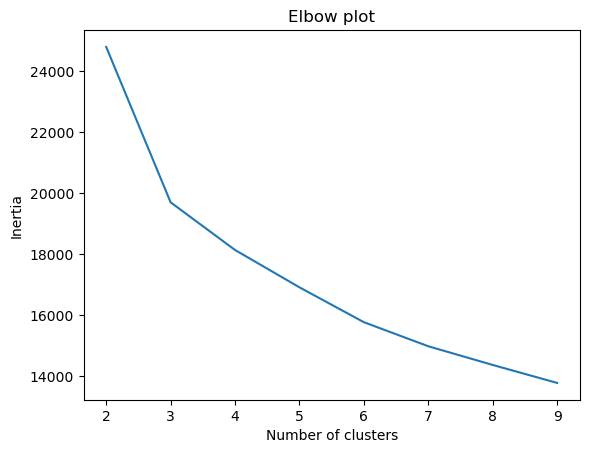

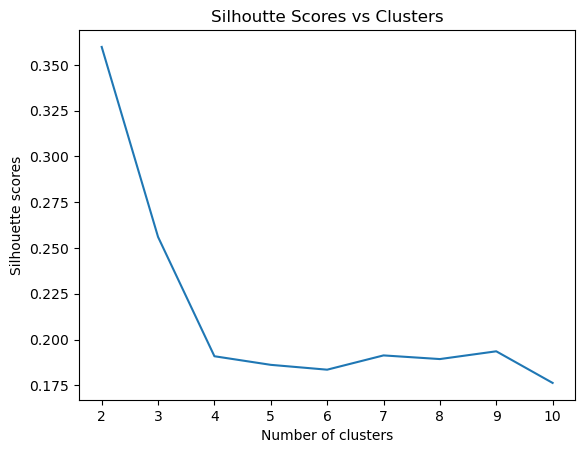

In [21]:
X_pca = acp_avgpool_learner.pick_k()

Cluster counts: Counter({0: 488, 2: 391, 1: 298, 4: 257, 5: 208, 3: 80})


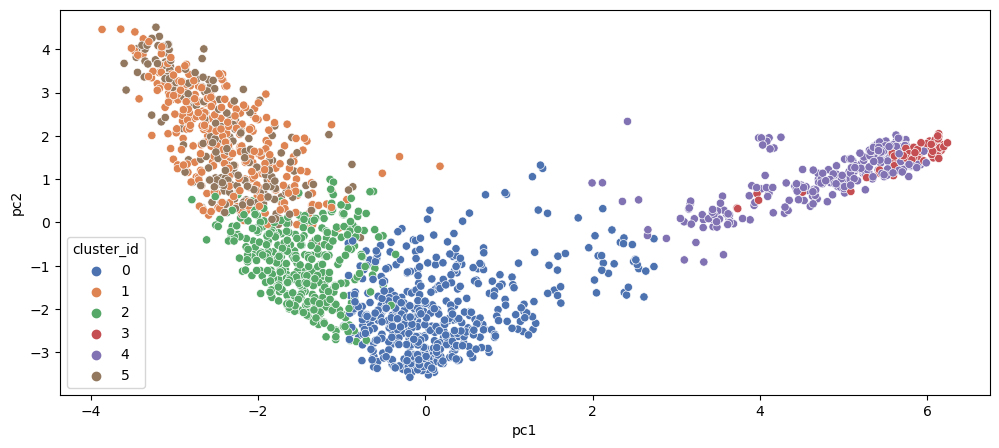

In [22]:
acp_avgpool_learner.analyze_clusters(X_pca, k=6)

## Antimicrobial Peptide Dataset (AMP)

### AMP - PCA vs Full Data

In [23]:
X_train, y_train, X_test, y_test = amp_data.get_lstm_emb('amp_avgpool_train.h5', 'amp_avgpool_test.h5')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3234, 6165), (3234,), (808, 6165), (808,))

In [24]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(
    f"Explained variance ratio of the first 10 principal components:\n{pca.explained_variance_ratio_[:10]}"
)

X_train_pca.shape: (3234, 50)
Explained variance ratio of the first 10 principal components:
[0.16400845 0.15573642 0.04399751 0.03372195 0.02795825 0.02183319
 0.01885984 0.01691326 0.01427688 0.01275587]


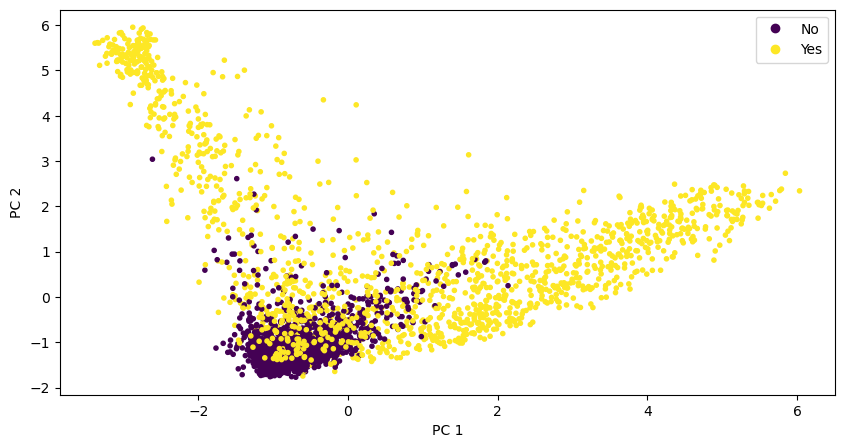

In [25]:
visualize_2pcs(X_train_pca, y_train)

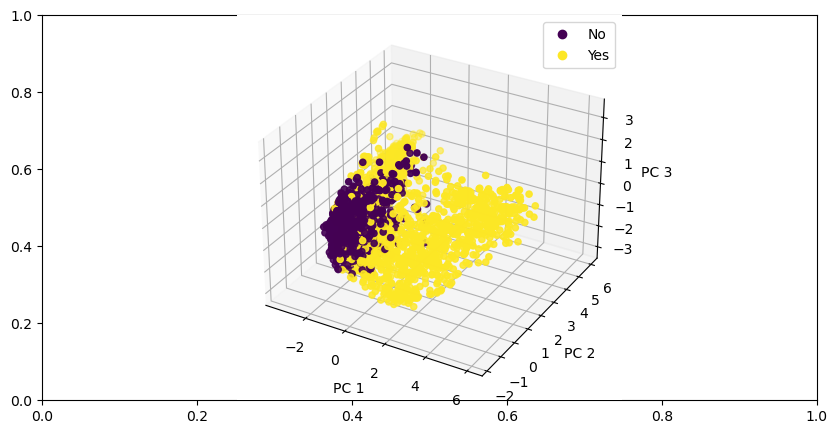

In [26]:
visualize_3pcs(X_train_pca, y_train)

Evaluation on full data

In [27]:
train_predict(X_train, y_train, X_test, y_test)

,acc,recall,precision,f1
lr,0.931931,0.919395,0.940722,0.929936
svc,0.925743,0.911839,0.935401,0.923469
xgb,0.929455,0.901763,0.952128,0.926261


Evaluation on reduced data

In [28]:
X_test_pca = pca.transform(X_test)
train_predict(X_train_pca, y_train, X_test_pca, y_test)

,acc,recall,precision,f1
lr,0.923267,0.904282,0.937337,0.920513
svc,0.924505,0.899244,0.944444,0.921290
xgb,0.919554,0.886650,0.946237,0.915475


### AMP - Get Data and Learners (Avg vs Max Pooling)

In [29]:
# max
X_train, y_train, X_test, y_test = amp_data.get_lstm_emb('amp_maxpool_train.h5', 'amp_maxpool_test.h5')
amp_maxpool_learner = Learner(X_train, y_train, X_test, y_test)

# avg
X_train, y_train, X_test, y_test = amp_data.get_lstm_emb('amp_avgpool_train.h5', 'amp_avgpool_test.h5')
amp_avgpool_learner = Learner(X_train, y_train, X_test, y_test)

### AMP - Grid Search (Supervised Learning)

In [30]:
amp_avgpool_learner.pipeline.steps

[('pca', PCA(n_components=50)), ('classifier', 'passthrough')]

In [31]:
#hide_output

_, _ = amp_avgpool_learner.train()

Starting grid search for LogisticRegression
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Starting grid search for LinearSVC
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2

Starting grid search for XGBClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Run  grid search on max pooled embedding to compare results

In [32]:
#hide_output

_, _ = amp_maxpool_learner.train()

Starting grid search for LogisticRegression
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Starting grid search for LinearSVC
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2

Starting grid search for XGBClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits


### AMP - Label Spreading (Semi Supervised Learning)

In [33]:
amp_maxpool_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       411
           1       0.96      0.88      0.92       397

    accuracy                           0.92       808
   macro avg       0.93      0.92      0.92       808
weighted avg       0.92      0.92      0.92       808



In [34]:
amp_avgpool_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       411
           1       0.95      0.89      0.92       397

    accuracy                           0.92       808
   macro avg       0.92      0.92      0.92       808
weighted avg       0.92      0.92      0.92       808



No winner

### AMP - Prediction Results
Comparing prediction performance between avg and max pooled embedding

In [35]:
amp_avgpool_learner.predict()

,best_params,accuracy,recall,precision,f1
LogisticRegression,"{'classifier': LogisticRegression(C=100.0, max...",0.92698,0.90932,0.940104,0.924456
LinearSVC,"{'classifier': LinearSVC(C=100.0, loss='hinge'...",0.92698,0.906801,0.942408,0.924262
XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.925743,0.896725,0.949333,0.92228
LabelSpreading,"{'alpha': 0.01, 'gamma': 20, 'kernel': 'knn', ...",0.92203,0.891688,0.946524,0.918288


In [36]:
amp_maxpool_learner.predict()

,best_params,accuracy,recall,precision,f1
LogisticRegression,"{'classifier': LogisticRegression(C=100.0, max...",0.928218,0.911839,0.94026,0.925831
LinearSVC,"{'classifier': LinearSVC(loss='hinge', max_ite...",0.930693,0.914358,0.942857,0.928389
XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.924505,0.90932,0.935233,0.922095
LabelSpreading,"{'alpha': 0.01, 'gamma': 20, 'kernel': 'knn', ...",0.92203,0.879093,0.958791,0.917214


Again XBG shows improvement with max pooled embeddings

Save results.

In [37]:
amp_avgpool_learner.predict_results.to_csv(f'{EXPERIMENT_STORE}/amp_lstm_avgpool_learner.csv')
amp_maxpool_learner.predict_results.to_csv(f'{EXPERIMENT_STORE}/amp_lstm_maxpool_learner.csv')

### AMP - KMeans Clustering (Unsupervised Learning)

n_clusters: 2 -- avg silhouette score: 0.4392211437225342
n_clusters: 3 -- avg silhouette score: 0.30619361996650696
n_clusters: 4 -- avg silhouette score: 0.3071313202381134
n_clusters: 5 -- avg silhouette score: 0.20854830741882324
n_clusters: 6 -- avg silhouette score: 0.19198007881641388
n_clusters: 7 -- avg silhouette score: 0.188777893781662
n_clusters: 8 -- avg silhouette score: 0.18562379479408264
n_clusters: 9 -- avg silhouette score: 0.18900585174560547
n_clusters: 10 -- avg silhouette score: 0.15258486568927765


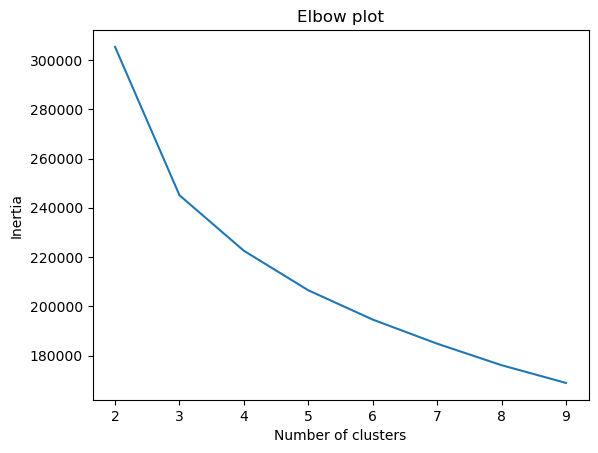

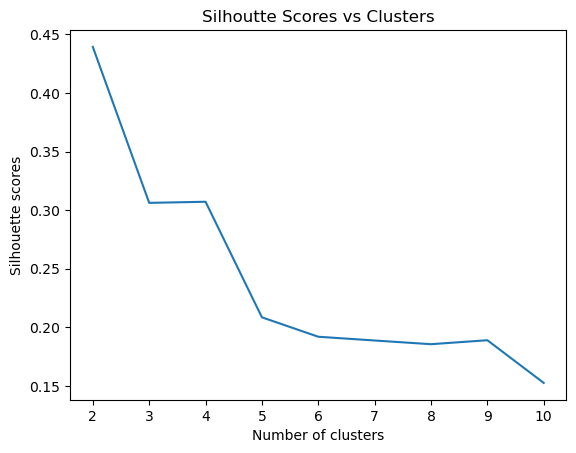

In [38]:
X_pca = amp_maxpool_learner.pick_k()

Cluster counts: Counter({1: 2363, 0: 670, 2: 605, 3: 404})


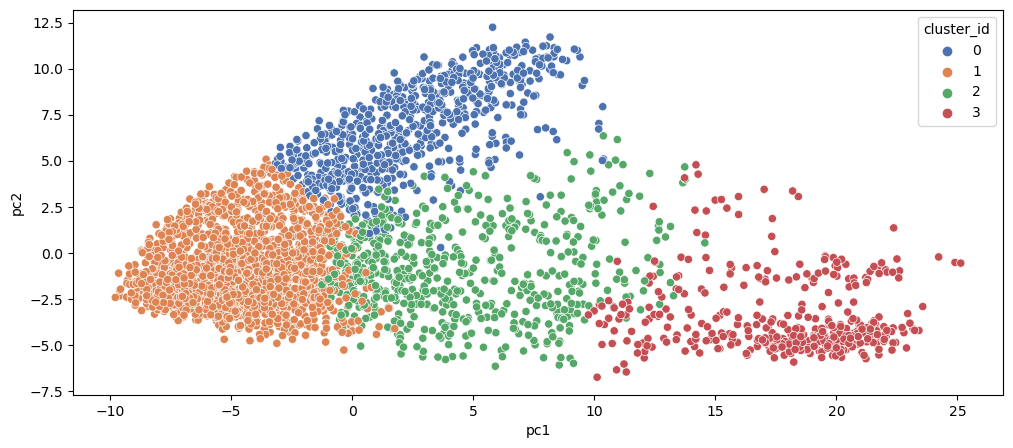

In [39]:
amp_maxpool_learner.analyze_clusters(X_pca, k=4)

## DNA Binding Dataset

### DNA - PCA vs Full

In [40]:
X_train, y_train, X_test, y_test = dna_data.get_lstm_emb('dna_avgpool_train.h5', 'dna_avgpool_test.h5')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14189, 6165), (14189,), (2272, 6165), (2272,))

In [41]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(
    f"Explained variance ratio of the first 10 principal components:\n{pca.explained_variance_ratio_[:10]}"
)

X_train_pca.shape: (14189, 50)
Explained variance ratio of the first 10 principal components:
[0.14483151 0.08522432 0.04459034 0.0348114  0.03089704 0.0273882
 0.02518505 0.02346268 0.02010697 0.01673359]


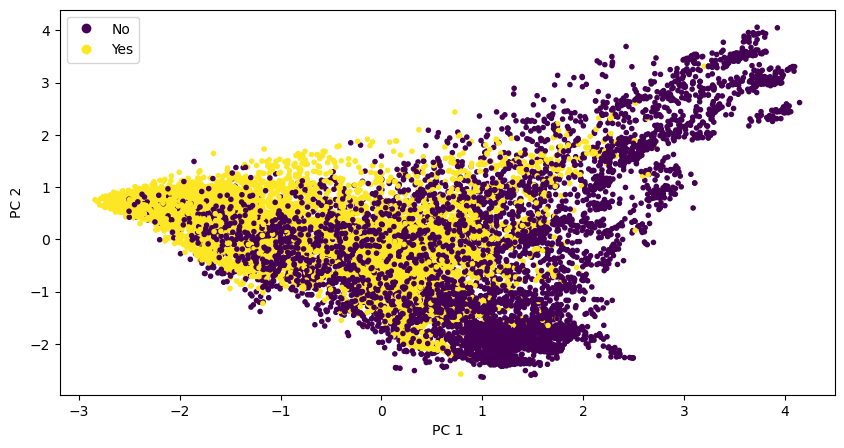

In [42]:
visualize_2pcs(X_train_pca, y_train)

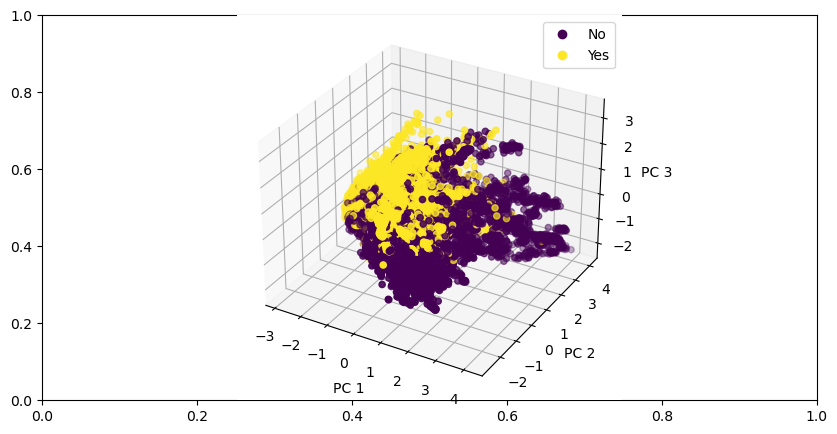

In [43]:
visualize_3pcs(X_train_pca, y_train)

Evaluation on full data

In [44]:
train_predict(X_train, y_train, X_test, y_test)

,acc,recall,precision,f1
lr,0.834067,0.889853,0.804075,0.844792
svc,0.841109,0.932350,0.791605,0.856233
xgb,0.879842,0.962706,0.828358,0.890493


Evaluation on reduced data

In [45]:
X_test_pca = pca.transform(X_test)
train_predict(X_train_pca, y_train, X_test_pca, y_test)

,acc,recall,precision,f1
lr,0.798415,0.844753,0.777334,0.809643
svc,0.796655,0.847355,0.773555,0.808775
xgb,0.869278,0.963573,0.813324,0.882096


### DNA - Get Data and Learners (Max vs Avg Pooling)

In [46]:
# max
X_train, y_train, X_test, y_test = dna_data.get_lstm_emb('dna_avgpool_train.h5', 'dna_avgpool_test.h5')
dna_maxpool_learner = Learner(X_train, y_train, X_test, y_test)

# avg
X_train, y_train, X_test, y_test = dna_data.get_lstm_emb('dna_avgpool_train.h5', 'dna_avgpool_test.h5')
dna_avgpool_learner = Learner(X_train, y_train, X_test, y_test)

### DNA - Grid Search (Supervised Learning)

In [47]:
dna_avgpool_learner.pipeline.steps

[('pca', PCA(n_components=50)), ('classifier', 'passthrough')]

In [48]:
#hide_output

_, _ = dna_avgpool_learner.train()

Starting grid search for LogisticRegression
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Starting grid search for LinearSVC
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2

Starting grid search for XGBClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Run  grid search on max pooled embedding to compare results

In [49]:
dna_maxpool_learner.pipeline.steps

[('pca', PCA(n_components=50)), ('classifier', 'passthrough')]

In [50]:
#hide_output

_, _ = dna_maxpool_learner.train()

Starting grid search for LogisticRegression
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Starting grid search for LinearSVC
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2

Starting grid search for XGBClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits


### DNA - Label Spreading (Semi Supervised Learning)

In [51]:
dna_maxpool_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.89      0.72      0.79      1119
           1       0.77      0.91      0.83      1153

    accuracy                           0.81      2272
   macro avg       0.83      0.81      0.81      2272
weighted avg       0.83      0.81      0.81      2272



In [52]:
dna_avgpool_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1119
           1       0.77      0.91      0.83      1153

    accuracy                           0.81      2272
   macro avg       0.83      0.81      0.81      2272
weighted avg       0.83      0.81      0.81      2272



#### DNA - Prediction Results
Comparing prediction performance between avg and max pooled embedding

In [53]:
dna_avgpool_learner.predict()

,best_params,accuracy,recall,precision,f1
LogisticRegression,"{'classifier': LogisticRegression(C=100.0, max...",0.802377,0.847355,0.7816,0.81315
LinearSVC,"{'classifier': LinearSVC(C=10.0, loss='hinge',...",0.800616,0.85516,0.775157,0.813196
XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.875,0.964441,0.820664,0.886762
LabelSpreading,"{'alpha': 0.01, 'gamma': 20, 'kernel': 'knn', ...",0.81338,0.911535,0.765477,0.832146


In [54]:
dna_maxpool_learner.predict()

,best_params,accuracy,recall,precision,f1
LogisticRegression,{'classifier': LogisticRegression(max_iter=100...,0.801496,0.848222,0.779904,0.81263
LinearSVC,"{'classifier': LinearSVC(C=100.0, loss='hinge'...",0.805018,0.847355,0.78537,0.815186
XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.865757,0.961839,0.809489,0.879112
LabelSpreading,"{'alpha': 0.01, 'gamma': 20, 'kernel': 'knn', ...",0.814701,0.910668,0.767544,0.833003


Again XBG shows improvement with max pooled embeddings.

Save results.

In [55]:
dna_avgpool_learner.predict_results.to_csv(f'{EXPERIMENT_STORE}/dna_lstm_avgpool_learner.csv')
dna_maxpool_learner.predict_results.to_csv(f'{EXPERIMENT_STORE}/dna_lstm_maxpool_learner.csv')

### DNA - KMeans Clustering (Unsupervised Learning)

n_clusters: 2 -- avg silhouette score: 0.13949118554592133
n_clusters: 3 -- avg silhouette score: 0.15438680350780487
n_clusters: 4 -- avg silhouette score: 0.14487028121948242
n_clusters: 5 -- avg silhouette score: 0.12199439108371735
n_clusters: 6 -- avg silhouette score: 0.11718294024467468
n_clusters: 7 -- avg silhouette score: 0.1381966769695282
n_clusters: 8 -- avg silhouette score: 0.13304507732391357
n_clusters: 9 -- avg silhouette score: 0.13672156631946564
n_clusters: 10 -- avg silhouette score: 0.10999424010515213


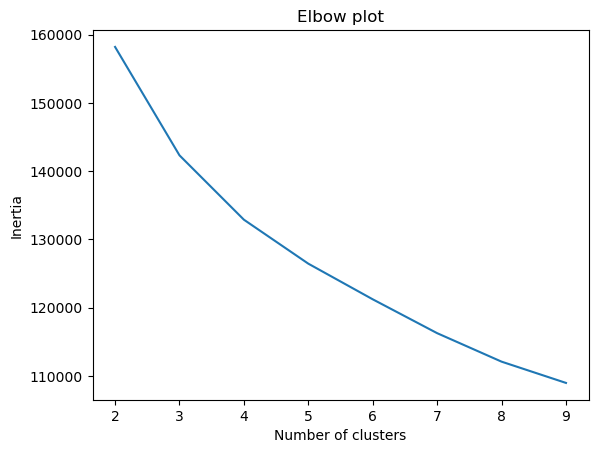

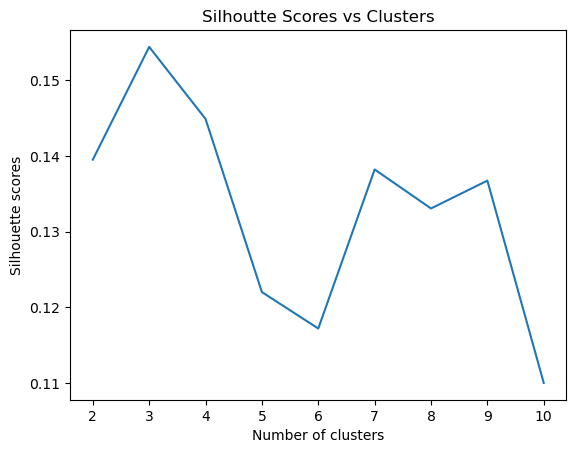

In [56]:
X_pca = dna_maxpool_learner.pick_k()

Cluster counts: Counter({3: 3971, 4: 3876, 0: 3620, 1: 3066, 5: 1364, 2: 564})


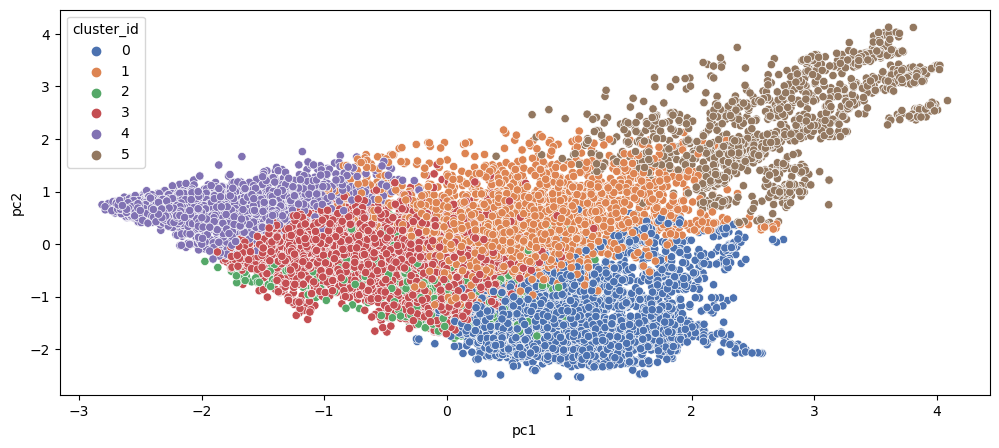

In [57]:
dna_maxpool_learner.analyze_clusters(X_pca, k=6)

## Export -

In [58]:
# hide
from nbdev.export import *

notebook2script()


Converted 00_basics.ipynb.
Converted 01_data.ipynb.
Converted 02_learn.ipynb.
Converted 03_onehot.ipynb.
Converted 04_lstm.ipynb.
Converted 05_transformer.ipynb.
Converted 99_utils.ipynb.
Converted index.ipynb.
